In [30]:
import sys
import os

# Imposta PROJECT_ROOT come la cartella principale (astromark-ai), un livello sopra "notebook"
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)
print("[INFO] Project root aggiunto a sys.path:", PROJECT_ROOT)

[INFO] Project root aggiunto a sys.path: C:\Users\Mario\PycharmProjects\astromark-ai


# Notebook Astromark AI

Questo notebook carica i dati dei ticket, li unisce e li preprocessa (utilizzando spaCy per tokenizzazione, lemmatizzazione e NER), costruisce la pipeline di ML, esegue la grid search, salva/carica il modello e infine fornisce un esempio di utilizzo del ticket service.

In [31]:
import os
import re
import joblib
import pandas as pd
import spacy
from joblib import Parallel, delayed, parallel_backend
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Imposta i percorsi relativi al project root
BASE_DIR = PROJECT_ROOT
DATA_RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')
TRAINED_DIR = os.path.join(BASE_DIR, 'data', 'trained')

TICKET_O3_PATH = os.path.join(DATA_RAW_DIR, 'ticket-o3.csv')
TICKET_GEMINI_PATH = os.path.join(DATA_RAW_DIR, 'ticket-gemini-claude.csv')
PROCESSED_DATA_PATH = os.path.join(PROCESSED_DIR, 'X_processed.csv')

os.makedirs(DATA_RAW_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(TRAINED_DIR, exist_ok=True)

print('[INFO] Percorso per ticket-o3:', TICKET_O3_PATH)
print('[INFO] Percorso per ticket-gemini:', TICKET_GEMINI_PATH)

[INFO] Percorso per ticket-o3: C:\Users\Mario\PycharmProjects\astromark-ai\data\raw\ticket-o3.csv
[INFO] Percorso per ticket-gemini: C:\Users\Mario\PycharmProjects\astromark-ai\data\raw\ticket-gemini-claude.csv


In [32]:
# Caricamento e unione dei dati
print('[INFO] Caricamento di ticket-o3...')
dataframe_o3 = pd.read_csv(TICKET_O3_PATH, usecols=['titolo', 'messaggio', 'categoria'])
print(f'[INFO] ticket-o3.csv caricato con shape: {dataframe_o3.shape}')

print('[INFO] Caricamento di ticket-gemini-claude...')
dataframe_gc = pd.read_csv(TICKET_GEMINI_PATH, usecols=['titolo', 'messaggio', 'categoria'])
print(f'[INFO] ticket-gemini-claude.csv caricato con shape: {dataframe_gc.shape}')

def merge_dataframes(frame1, frame2):
    print('[INFO] Unione dei dataframe...')
    frame = pd.concat([frame1, frame2])
    
    num_duplicated = frame.duplicated().sum()
    frame.drop_duplicates(inplace=True)
    print(f'[INFO] Eliminate {num_duplicated} righe duplicate:')
    
    frame['titolo_messaggio'] = frame['titolo'] + ' ' + frame['messaggio']
    return frame[['titolo_messaggio', 'categoria']]

merged_df = merge_dataframes(dataframe_o3, dataframe_gc)
X = merged_df['titolo_messaggio']
y = merged_df['categoria']
print(f'[INFO] Dataset unito finale: {merged_df.shape}')

[INFO] Caricamento di ticket-o3...
[INFO] ticket-o3.csv caricato con shape: (4662, 3)
[INFO] Caricamento di ticket-gemini-claude...
[INFO] ticket-gemini-claude.csv caricato con shape: (866, 3)
[INFO] Unione dei dataframe...
[INFO] Eliminate 291 righe duplicate:
[INFO] Dataset unito finale: (5237, 2)



Statistiche descrittive per categoria:
categoria
Segreteria    1088
Didattica     1085
Tecnico       1072
Accesso       1007
Profilo        985
dtype: int64

Percentuali per categoria:
categoria
Segreteria    20.78
Didattica     20.72
Tecnico       20.47
Accesso       19.23
Profilo       18.81
Name: proportion, dtype: float64


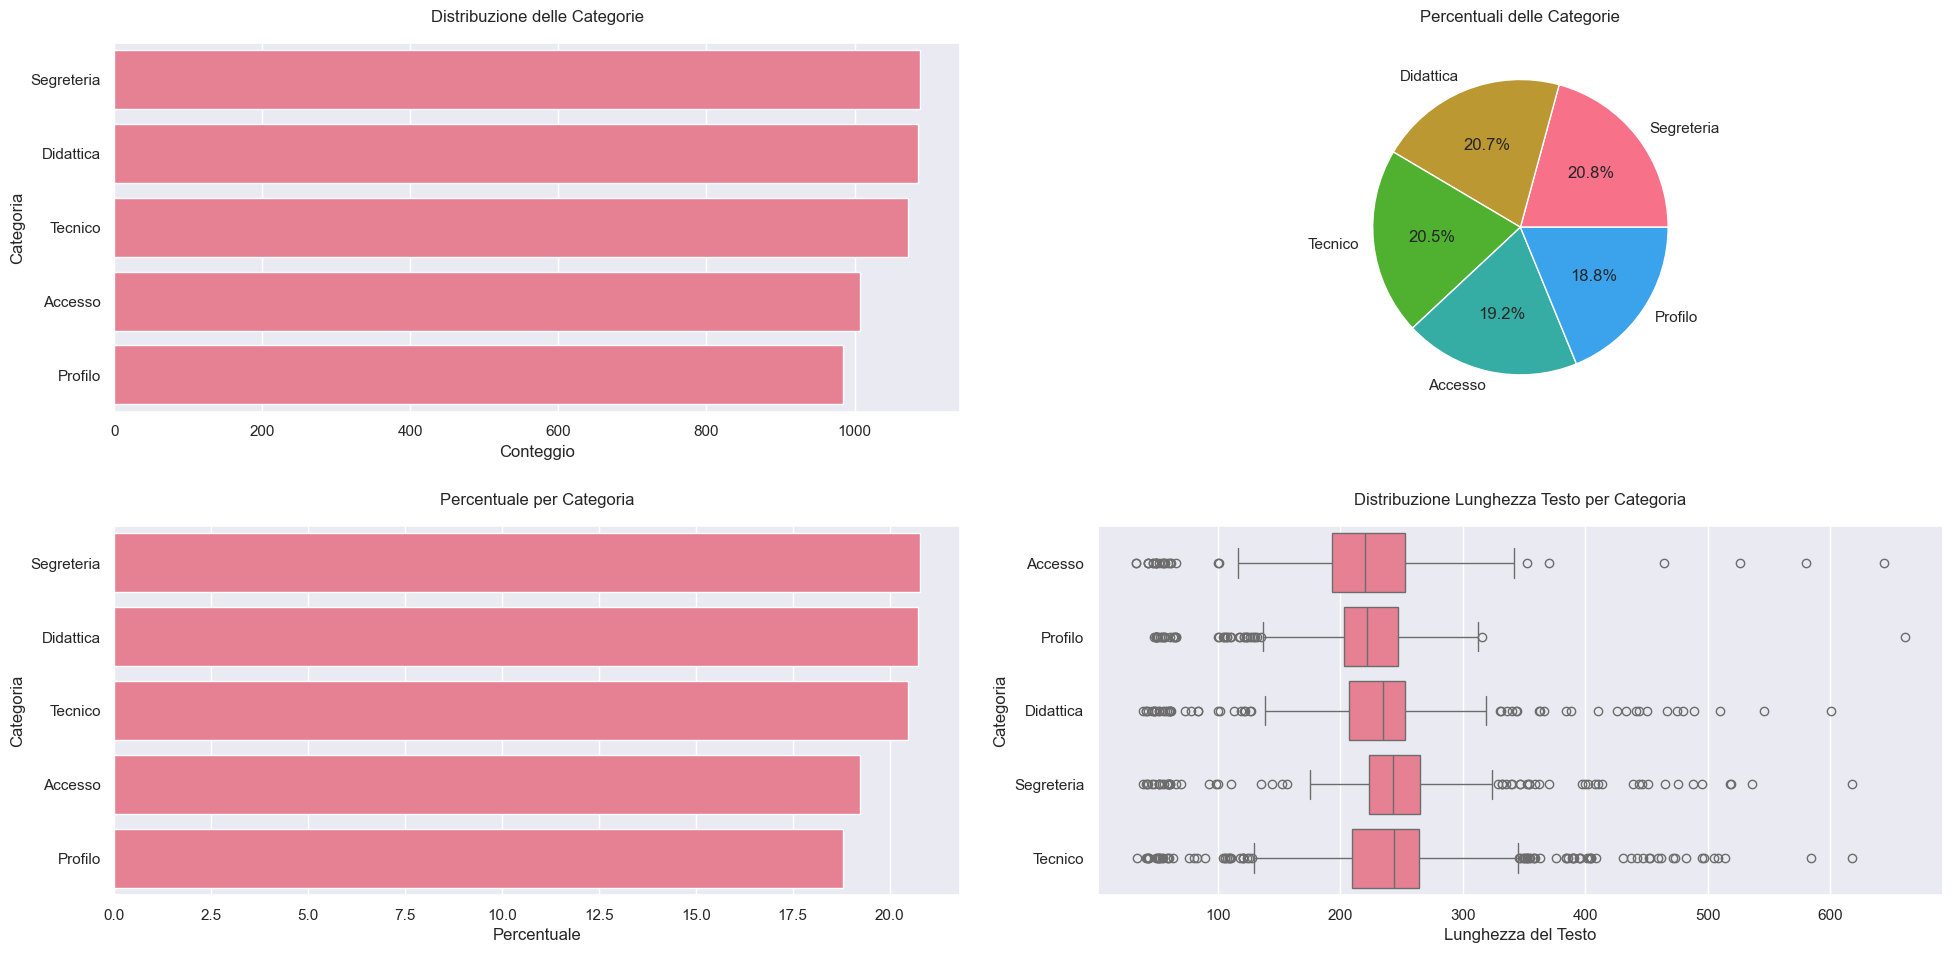

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Impostazioni per una migliore visualizzazione
plt.style.use('default')  # Utilizziamo lo stile default di matplotlib
sns.set_theme()  # Applica il tema base di seaborn
sns.set_palette("husl")

# Creazione di una figura con più sottografici
fig = plt.figure(figsize=(20, 10))

# 1. Grafico a barre della distribuzione delle categorie
plt.subplot(2, 2, 1)
sns.countplot(data=merged_df, y='categoria', order=merged_df['categoria'].value_counts().index)
plt.title('Distribuzione delle Categorie', pad=15)
plt.xlabel('Conteggio')
plt.ylabel('Categoria')

# 2. Grafico a torta delle percentuali
plt.subplot(2, 2, 2)
category_counts = merged_df['categoria'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Percentuali delle Categorie', pad=15)

# 3. Grafico a barre orizzontale con percentuali
plt.subplot(2, 2, 3)
category_percentages = (merged_df['categoria'].value_counts(normalize=True) * 100)
sns.barplot(x=category_percentages.values, y=category_percentages.index)
plt.title('Percentuale per Categoria', pad=15)
plt.xlabel('Percentuale')
plt.ylabel('Categoria')

# 4. Box plot della lunghezza del testo per categoria
plt.subplot(2, 2, 4)
merged_df['text_length'] = merged_df['titolo_messaggio'].str.len()
sns.boxplot(data=merged_df, x='text_length', y='categoria')
plt.title('Distribuzione Lunghezza Testo per Categoria', pad=15)
plt.xlabel('Lunghezza del Testo')
plt.ylabel('Categoria')

# Aggiusta il layout
plt.tight_layout(pad=2.0)

# Mostra statistiche descrittive
print("\nStatistiche descrittive per categoria:")
print(merged_df.groupby('categoria').size().sort_values(ascending=False))
print("\nPercentuali per categoria:")
print(category_percentages.round(2))

# Mostra il plot
plt.show()

In [34]:
# Preprocessing minimo del testo con spaCy
print('[INFO] Caricamento del modello spaCy (it_core_news_sm)...')
nlp = spacy.load('it_core_news_sm')

# Definiamo i saluti da rimuovere
GREETINGS_PATTERNS = [
    r'\bciao\b', r'\bbuongiorno\b', r'\bsalve\b',
    r'\bbuonasera\b', r'\bbuon pomeriggio\b', r'\barrivederci\b',
    r'\bbuonanotte\b', r'\ba presto\b', r'\baddio\b', r'\bsaluti\b'
]

def remove_greetings(text):
    pattern = re.compile('|'.join(GREETINGS_PATTERNS), flags=re.IGNORECASE)
    return pattern.sub('', text)

def minimal_preprocess(text):
    text = text.lower().strip()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # rimozione URL
    text = remove_greetings(text)
    text = re.sub(r'[^\w\s]', ' ', text)  # rimozione punteggiatura
    text = re.sub(r'\d+', '', text)  # rimozione numeri
    text = re.sub(r'\s+', ' ', text)  # normalizzazione spazi
    return text.strip()

def process_text(text):
    cleaned_text = minimal_preprocess(text)
    doc = nlp(cleaned_text)
    tokens = []
    for token in doc:
        if token.is_stop or token.is_punct or token.is_space:
            continue
        lemma = token.lemma_
        if lemma:
            lemma = lemma.strip()
            if lemma:
                tokens.append(lemma)
    for ent in doc.ents:
        tokens.append(f"NER_{ent.label_}")
    return ' '.join(tokens)

def parallel_process_texts(series, n_jobs=-1):
    print('[INFO] Preprocessing in parallelo con backend threading...')
    with parallel_backend('threading', n_jobs=n_jobs):
        processed = Parallel()(delayed(process_text)(text) for text in series)
    return pd.Series(processed, index=series.index)

[INFO] Caricamento del modello spaCy (it_core_news_sm)...


In [35]:
# Carica o processa i dati preprocessati
if os.path.exists(PROCESSED_DATA_PATH):
    print(f"[INFO] Caricamento dei dati preprocessati da '{PROCESSED_DATA_PATH}'...")
    df = pd.read_csv(PROCESSED_DATA_PATH)
    X_processed = df["processed_text"]
else:
    print('[INFO] Dati preprocessati non trovati, inizio preprocessing in parallelo...')
    X_processed = parallel_process_texts(X, n_jobs=-1)
    print('[INFO] Salvataggio dei dati preprocessati in:', PROCESSED_DATA_PATH)
    X_processed_df = pd.DataFrame(X_processed, columns=["processed_text"])
    X_processed_df.to_csv(PROCESSED_DATA_PATH, index=False)
    print('[INFO] Preprocessing completato e memorizzato.')

[INFO] Dati preprocessati non trovati, inizio preprocessing in parallelo...
[INFO] Preprocessing in parallelo con backend threading...
[INFO] Salvataggio dei dati preprocessati in: C:\Users\Mario\PycharmProjects\astromark-ai\data\processed\X_processed.csv
[INFO] Preprocessing completato e memorizzato.


In [36]:
from service.pipeline import ClassifierType
from sklearn.pipeline import Pipeline


# Funzioni per costruire la pipeline e la Grid Search
def build_pipeline(classifier_type):
    tfidf = TfidfVectorizer(
        use_idf=True,
        ngram_range=(1, 1),
        max_features=2000,
        norm='l2',
        smooth_idf=True,
        sublinear_tf=True
    )

    if classifier_type == ClassifierType.NAIVE_BAYES:
        classifier = MultinomialNB()
        pipeline = Pipeline([
            ('tfidf', tfidf),
            ('clf', classifier)
        ])
        param_grid = {
            'tfidf__min_df': [1, 3],
            'tfidf__max_df': [0.85, 0.90],
            'clf__alpha': [1.0, 1.5, 2.0]
        }
    elif classifier_type == ClassifierType.SVM:
        svd = TruncatedSVD(n_components=50, random_state=42)
        classifier = SVC(probability=True, kernel='linear', random_state=42)
        pipeline = Pipeline([
            ('tfidf', tfidf),
            ('svd', svd),
            ('clf', classifier)
        ])
        param_grid = {
            'tfidf__min_df': [1, 3],
            'tfidf__max_df': [0.85, 0.90],
            'svd__n_components': [30, 50],
            'clf__C': [0.1, 0.5, 1.0]
        }
    else:
        raise ValueError("Unsupported classifier type.")
    return pipeline, param_grid

def perform_grid_search(X, y, classifier_type):
    print(f"[INFO] Costruisco la pipeline per {classifier_type.value}...")
    pipeline, param_grid = build_pipeline(classifier_type)
    print(f"[INFO] Avvio Grid Search per {classifier_type.value} con parametri: {param_grid}")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(pipeline, param_grid, cv=skf, n_jobs=-1, verbose=1)
    grid.fit(X, y)
    print(f"[INFO] Grid Search per {classifier_type.value} completata.")
    print(f"[INFO] Parametri migliori: {grid.best_params_}")
    return grid.best_estimator_


In [37]:
# Funzioni per salvare/caricare il modello
MODEL_PATHS = {
    "naive_bayes": os.path.join(TRAINED_DIR, "trained_model_nb.pkl"),
    "svm": os.path.join(TRAINED_DIR, "trained_model_svm.pkl")
}

def save_model(model, classifier_type):
    path = MODEL_PATHS[classifier_type.value]
    joblib.dump(model, path)
    print(f"[INFO] Modello salvato in {path}.")

def load_model(classifier_type):
    path = MODEL_PATHS[classifier_type.value]
    if os.path.exists(path):
        print(f"[INFO] Caricamento del modello da {path}...")
        return joblib.load(path)
    return None

def get_model(classifier_type):
    """Se esiste un modello preaddestrato, lo carica; altrimenti esegue la grid search e lo salva."""
    model = load_model(classifier_type)
    if model is None:
        print(f"[INFO] Nessun modello salvato per {classifier_type.value}. Avvio training...")
        model = perform_grid_search(X_processed, y, classifier_type)
        save_model(model, classifier_type)
    else:
        print(f"[INFO] Uso il modello salvato per {classifier_type.value}.")
    return model

## Fine della Pipeline

I dati sono stati caricati, preprocessati e il modello (ottenuto tramite Grid Search) è stato caricato o addestrato e salvato nella cartella `../data/trained`.

In [38]:
# Esempio: Funzione per il Ticket Service
def ticket_service(title, message, classifier_type):
    print(f"[INFO] Classificatore selezionato: {classifier_type.value}")
    print("[INFO] Recupero del modello finale (lo carico se già esistente)...")
    get_model(classifier_type)
    full_text = f"{title} {message}".strip()
    if not full_text:
        return ["Nessun input fornito"]
    # Importa la funzione predict_category dal modulo report_predict
    from service.report_predict import predict_category
    predictions = predict_category(full_text, classifier_type)
    print("Predizioni:", predictions)
    return predictions



## Esempio di utilizzo con SVM

In [39]:

example_title = "Problema con la stampante"
example_message = "La stampante non funziona correttamente."
svm_predictions = ticket_service(example_title, example_message, ClassifierType.SVM)
pd.DataFrame(svm_predictions, columns=["Class", "Probability"])

[INFO] Classificatore selezionato: svm
[INFO] Recupero del modello finale (lo carico se già esistente)...
[INFO] Nessun modello salvato per svm. Avvio training...
[INFO] Costruisco la pipeline per svm...
[INFO] Avvio Grid Search per svm con parametri: {'tfidf__min_df': [1, 3], 'tfidf__max_df': [0.85, 0.9], 'svd__n_components': [30, 50], 'clf__C': [0.1, 0.5, 1.0]}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[INFO] Predicting category for a new message...
[INFO] Loading saved model from C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_svm.pkl...
[INFO] Using saved model for svm.


[INFO] Grid Search per svm completata.
[INFO] Parametri migliori: {'clf__C': 1.0, 'svd__n_components': 50, 'tfidf__max_df': 0.85, 'tfidf__min_df': 3}
[INFO] Modello salvato in C:\Users\Mario\PycharmProjects\astromark-ai\data\trained\trained_model_svm.pkl.
Predizioni: [('Tecnico', np.float64(0.9519120555167939)), ('Accesso', np.float64(0.02507903459709784)), ('Didattica', np.float64(0.011586521695589472))]


,Class,Probability
0,Tecnico,0.951912
1,Accesso,0.025079
2,Didattica,0.011587


## Esempio di utilizzo con NAIVE BAYES

In [40]:
example_title = "Problema con la stampante"
example_message = "La stampante non funziona correttamente."
naive_bayes_predictions = ticket_service(example_title, example_message, ClassifierType.NAIVE_BAYES)
pd.DataFrame(naive_bayes_predictions, columns=["Class", "Probability"])

[INFO] Classificatore selezionato: naive_bayes
[INFO] Recupero del modello finale (lo carico se già esistente)...
[INFO] Nessun modello salvato per naive_bayes. Avvio training...
[INFO] Costruisco la pipeline per naive_bayes...
[INFO] Avvio Grid Search per naive_bayes con parametri: {'tfidf__min_df': [1, 3], 'tfidf__max_df': [0.85, 0.9], 'clf__alpha': [1.0, 1.5, 2.0]}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[INFO] Predicting category for a new message...
[INFO] Loading saved model from C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_nb.pkl...
[INFO] Using saved model for naive_bayes.


[INFO] Grid Search per naive_bayes completata.
[INFO] Parametri migliori: {'clf__alpha': 1.0, 'tfidf__max_df': 0.85, 'tfidf__min_df': 3}
[INFO] Modello salvato in C:\Users\Mario\PycharmProjects\astromark-ai\data\trained\trained_model_nb.pkl.
Predizioni: [(np.str_('Tecnico'), np.float64(0.7570816526658218)), (np.str_('Accesso'), np.float64(0.08639834082249236)), (np.str_('Profilo'), np.float64(0.05684463408153303))]


,Class,Probability
0,Tecnico,0.757082
1,Accesso,0.086398
2,Profilo,0.056845
